In [1]:
import torch
import torch.nn as nn

In [2]:
# This UNET-style prediction model was originally included as part of the Score-based generative modelling tutorial 
# by Yang Song et al: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torchmetrics.image.inception import InceptionScore #https://lightning.ai/docs/torchmetrics/stable/image/inception_score.html
from torchmetrics.image.fid import FrechetInceptionDistance # https://lightning.ai/docs/torchmetrics/stable/image/frechet_inception_distance.html


class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""  
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed 
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])    

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)    
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)    
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
  
  def forward(self, x, t): 
    # Obtain the Gaussian random feature embedding for t   
    embed = self.act(self.embed(t))    
    # Encoding path
    h1 = self.conv1(x)    
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [3]:
# ExponentialMovingAverage implementation as used in pytorch vision
# https://github.com/pytorch/vision/blob/main/references/classification/utils.py#L159

# BSD 3-Clause License

# Copyright (c) Soumith Chintala 2016, 
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# * Redistributions of source code must retain the above copyright notice, this
#   list of conditions and the following disclaimer.

# * Redistributions in binary form must reproduce the above copyright notice,
#   this list of conditions and the following disclaimer in the documentation
#   and/or other materials provided with the distribution.

# * Neither the name of the copyright holder nor the names of its
#   contributors may be used to endorse or promote products derived from
#   this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
    
class ExponentialMovingAverage(torch.optim.swa_utils.AveragedModel):
    """Maintains moving averages of model parameters using an exponential decay.
    ``ema_avg = decay * avg_model_param + (1 - decay) * model_param``
    `torch.optim.swa_utils.AveragedModel <https://pytorch.org/docs/stable/optim.html#custom-averaging-strategies>`_
    is used to compute the EMA.
    """

    def __init__(self, model, decay, device="cpu"):
        def ema_avg(avg_model_param, model_param, num_averaged):
            return decay * avg_model_param + (1 - decay) * model_param

        super().__init__(model, device, ema_avg, use_buffers=True)

In [4]:
from torchvision import datasets, transforms, utils
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math

class DDPM(nn.Module):

    def __init__(self, network, T=100, beta_1=1e-4, beta_T=2e-2):
        """
        Initialize Denoising Diffusion Probabilistic Model

        Parameters
        ----------
        network: nn.Module
            The inner neural network used by the diffusion process. Typically a Unet.
        beta_1: float
            beta_t value at t=1 
        beta_T: [float]
            beta_t value at t=T (last step)
        T: int
            The number of diffusion steps.
        """
        
        super(DDPM, self).__init__()

        # Normalize time input before evaluating neural network
        # Reshape input into image format and normalize time value before sending it to network model
        self._network = network
        self.network = lambda x, t: (self._network(x.reshape(-1, 1, 28, 28), 
                                                   (t.squeeze()/T))
                                    ).reshape(-1, 28*28)

        # Total number of time steps
        self.T = T

        # Registering as buffers to ensure they get transferred to the GPU automatically
        self.register_buffer("beta", torch.linspace(beta_1, beta_T, T+1))
        self.register_buffer("alpha", 1-self.beta)
        self.register_buffer("alpha_bar", self.alpha.cumprod(dim=0))
        

    def forward_diffusion(self, x0, t, epsilon):
        '''
        q(x_t | x_0)
        Forward diffusion from an input datapoint x0 to an xt at timestep t, provided a N(0,1) noise sample epsilon. 
        Note that we can do this operation in a single step

        Parameters
        ----------
        x0: torch.tensor
            x value at t=0 (an input image)
        t: int
            step index 
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t
        ''' 

        mean = torch.sqrt(self.alpha_bar[t])*x0
        std = torch.sqrt(1 - self.alpha_bar[t])
        
        return mean + std*epsilon

    def reverse_diffusion(self, xt, t, epsilon):
        """
        p(x_{t-1} | x_t)
        Single step in the reverse direction, from x_t (at timestep t) to x_{t-1}, provided a N(0,1) noise sample epsilon.

        Parameters
        ----------
        xt: torch.tensor
            x value at step t
        t: int
            step index
        epsilon:
            noise sample

        Returns
        -------
        torch.tensor
            image at timestep t-1
        """

        mean =  1./torch.sqrt(self.alpha[t]) * (xt - (self.beta[t])/torch.sqrt(1-self.alpha_bar[t])*self.network(xt, t)) 
        std = torch.where(t>0, torch.sqrt(((1-self.alpha_bar[t-1]) / (1-self.alpha_bar[t]))*self.beta[t]), 0)
        
        return mean + std*epsilon

    
    @torch.no_grad()
    def sample(self, shape):
        """
        Sample from diffusion model (Algorithm 2 in Ho et al, 2020)

        Parameters
        ----------
        shape: tuple
            Specify shape of sampled output. For MNIST: (nsamples, 28*28)

        Returns
        -------
        torch.tensor
            sampled image            
        """
        
        # Sample xT: Gaussian noise
        xT = torch.randn(shape).to(self.beta.device)

        xt = xT
        for t in range(self.T, 0, -1):
            noise = torch.randn_like(xT) if t > 1 else 0
            t = torch.tensor(t).expand(xt.shape[0], 1).to(self.beta.device)            
            xt = self.reverse_diffusion(xt, t, noise)

        return xt

    
    def elbo_simple(self, x0):
        """
        ELBO training objective (Algorithm 1 in Ho et al, 2020)

        Parameters
        ----------
        x0: torch.tensor
            Input image

        Returns
        -------
        float
            ELBO value            
        """

        # Sample time step t
        t = torch.randint(1, self.T, (x0.shape[0],1)).to(x0.device)
        
        # Sample noise
        epsilon = torch.randn_like(x0)

        # Forward diffusion to produce image at step t
        xt = self.forward_diffusion(x0, t, epsilon)
        
        return -nn.MSELoss(reduction='mean')(epsilon, self.network(xt, t))

    
    def loss(self, x0):
        """
        Loss function. Just the negative of the ELBO.
        """
        return -self.elbo_simple(x0).mean()


def train(model, optimizer, scheduler, dataloader, epochs, device, ema=True, per_epoch_callback=None):
    """
    Training loop
    
    Parameters
    ----------
    model: nn.Module
        Pytorch model
    optimizer: optim.Optimizer
        Pytorch optimizer to be used for training
    scheduler: optim.LRScheduler
        Pytorch learning rate scheduler
    dataloader: utils.DataLoader
        Pytorch dataloader
    epochs: int
        Number of epochs to train
    device: torch.device
        Pytorch device specification
    ema: Boolean
        Whether to activate Exponential Model Averaging
    per_epoch_callback: function
        Called at the end of every epoch
    """

    # Setup progress bar
    total_steps = len(dataloader)*epochs
    progress_bar = tqdm(range(total_steps), desc="Training")

    if ema:
        ema_global_step_counter = 0
        ema_steps = 10
        ema_adjust = dataloader.batch_size * ema_steps / epochs
        ema_decay = 1.0 - 0.995
        ema_alpha = min(1.0, (1.0 - ema_decay) * ema_adjust)
        ema_model = ExponentialMovingAverage(model, device=device, decay=1.0 - ema_alpha)                
    
    for epoch in range(epochs):

        # Switch to train mode
        model.train()

        global_step_counter = 0
        for i, (x, _) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # Update progress bar
            progress_bar.set_postfix(loss=f"⠀{loss.item():12.4f}", epoch=f"{epoch+1}/{epochs}", lr=f"{scheduler.get_last_lr()[0]:.2E}")
            progress_bar.update()
            
            global_step_counter += 1

            if ema:
                ema_global_step_counter += 1
                if ema_global_step_counter%ema_steps==0:
                    ema_model.update_parameters(model)                
        
        if per_epoch_callback:
            per_epoch_callback(ema_model.module if ema else model)


# Parameters
T = 1000
learning_rate = 1e-3
epochs = 100
batch_size = 256


# Rather than treating MNIST images as discrete objects, as done in Ho et al 2020, 
# we here treat them as continuous input data, by dequantizing the pixel values (adding noise to the input data)
# Also note that we map the 0..255 pixel values to [-1, 1], and that we process the 28x28 pixel values as a flattened 784 tensor.
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x + torch.rand(x.shape)/255),    # Dequantize pixel values
    transforms.Lambda(lambda x: (x-0.5)*2.0),                    # Map from [0,1] -> [-1, -1]
    transforms.Lambda(lambda x: x.flatten())
])

# Download and transform train dataset
dataloader_train = torch.utils.data.DataLoader(datasets.MNIST('./mnist_data', download=True, train=True, transform=transform),
                                                batch_size=batch_size,
                                                shuffle=True)

# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Construct Unet
# The original ScoreNet expects a function with std for all the
# different noise levels, such that the output can be rescaled.
# Since we are predicting the noise (rather than the score), we
# ignore this rescaling and just set std=1 for all t.
mnist_unet = ScoreNet((lambda t: torch.ones(1).to(device)))

# Construct model
model = DDPM(mnist_unet, T=T).to(device)

# Construct optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Setup simple scheduler
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)


def reporter(model):
    """Callback function used for plotting images during training"""
    
    # Switch to eval mode
    model.eval()

    with torch.no_grad():
        nsamples = 10
        samples = model.sample((nsamples,28*28)).cpu()
        
        # Map pixel values back from [-1,1] to [0,1]
        samples = (samples+1)/2 
        samples = samples.clamp(0.0, 1.0)

        # Plot in grid
        grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=nsamples)
        plt.gca().set_axis_off()
        plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
        plt.show()    


# Download and transform the test dataset
dataloader_test = torch.utils.data.DataLoader(
    datasets.MNIST('./mnist_data', download=True, train=False, transform=transform),
    batch_size=batch_size,
    shuffle=False  
)

def evaluate(model, dataloader_test, device, figname):
    """ #TODO# """
    model.eval()  

    with torch.no_grad():
        IS_means, IS_stds = [], []
        FID_scores = []
        inception = InceptionScore(normalize=True)
        fid = FrechetInceptionDistance(feature=64)
        for x, _ in tqdm(dataloader_test, desc="Evaluating"):
            batch_size = x.shape[0]
            #x = x.to(device)
            
            # visual inspection
            samples = model.sample((batch_size, 28 * 28)).cpu()
            samples = (samples + 1) / 2  # Rescale back to [0, 1]
            samples = samples.clamp(0, 1)
            grid = utils.make_grid(samples.reshape(-1, 1, 28, 28), nrow=5)
            # plt.imshow(transforms.functional.to_pil_image(grid), cmap="gray")
            # plt.axis('off')
            # plt.show()
            #plt.savefig(f"/opt/streamline/jmj/Courses/PLM/PLM_exam/predicted_mnist/{figname}_{counter}.png")

            sample = torch.tensor(samples, dtype=torch.uint8).view(batch_size, 1, 28, 28).repeat(1,3,1,1)
     
            # Inception score here 
            inception.update(sample)
            IS = inception.compute()
            IS_means.append(IS[0])
            IS_stds.append(IS[1])
            
            # FID score here 
            imgs_dist1 = torch.tensor(x[:batch_size,:], dtype=torch.uint8).view(batch_size, 1, 28, 28).repeat(1,3,1,1)
            imgs_dist2 = sample 
            fid.update(imgs_dist1, real=True)
            fid.update(imgs_dist2, real=False)
            FID_score = fid.compute()
            FID_scores.append(FID_score)
            
            # log-likelihood based score here
            # TODO # !!!
            
    print(f"Mean of IS means: {np.mean(IS_means)}")
    print(f"Mean of IS stds: {np.mean(IS_stds)}")
    print(f"Mean FID score: {np.mean(FID_scores)}")


/opt/conda_env/jmj/miniconda3/envs/plm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training:   1%|          | 234/23500 [00:04<07:13, 53.67it/s, epoch=1/100, loss=⠀      0.1490, lr=9.77E-04]

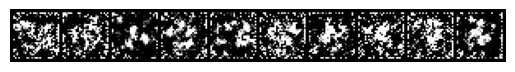

Training:   2%|▏         | 470/23500 [00:09<07:00, 54.74it/s, epoch=2/100, loss=⠀      0.0809, lr=9.54E-04]

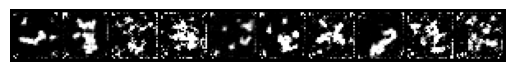

Training:   3%|▎         | 704/23500 [00:15<06:39, 57.02it/s, epoch=3/100, loss=⠀      0.0723, lr=9.32E-04]

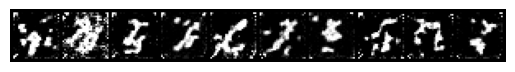

Training:   4%|▍         | 939/23500 [00:20<06:27, 58.16it/s, epoch=4/100, loss=⠀      0.0641, lr=9.10E-04]

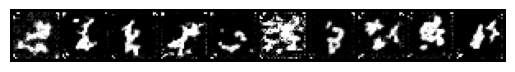

Training:   5%|▍         | 1174/23500 [00:25<06:20, 58.70it/s, epoch=5/100, loss=⠀      0.0660, lr=8.89E-04]

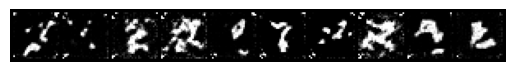

Training:   6%|▌         | 1409/23500 [00:30<06:25, 57.28it/s, epoch=6/100, loss=⠀      0.0641, lr=8.68E-04]

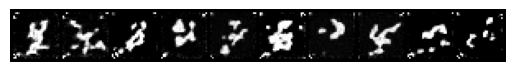

Training:   7%|▋         | 1644/23500 [00:35<06:19, 57.55it/s, epoch=7/100, loss=⠀      0.0595, lr=8.48E-04]

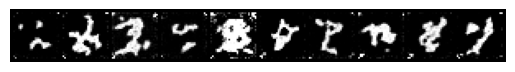

Training:   8%|▊         | 1879/23500 [00:40<06:13, 57.90it/s, epoch=8/100, loss=⠀      0.0503, lr=8.29E-04]

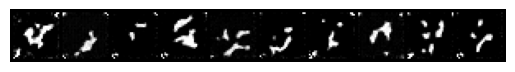

Training:   9%|▉         | 2114/23500 [00:45<06:11, 57.64it/s, epoch=9/100, loss=⠀      0.0445, lr=8.09E-04]

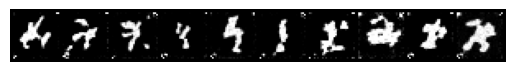

Training:  10%|▉         | 2349/23500 [00:50<06:08, 57.46it/s, epoch=10/100, loss=⠀      0.0506, lr=7.91E-04]

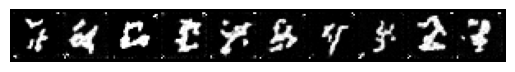

Training:  11%|█         | 2585/23500 [00:55<06:00, 58.09it/s, epoch=11/100, loss=⠀      0.0479, lr=7.72E-04]

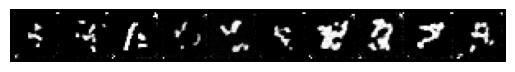

Training:  12%|█▏        | 2819/23500 [01:00<06:00, 57.35it/s, epoch=12/100, loss=⠀      0.0412, lr=7.54E-04]

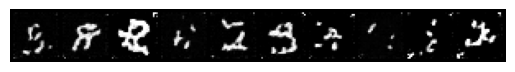

Training:  13%|█▎        | 3054/23500 [01:05<05:56, 57.32it/s, epoch=13/100, loss=⠀      0.0450, lr=7.37E-04]

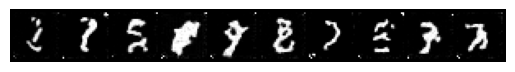

Training:  14%|█▍        | 3289/23500 [01:10<05:54, 57.06it/s, epoch=14/100, loss=⠀      0.0534, lr=7.20E-04]

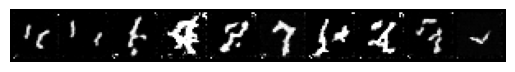

Training:  15%|█▍        | 3524/23500 [01:15<05:49, 57.11it/s, epoch=15/100, loss=⠀      0.0480, lr=7.03E-04]

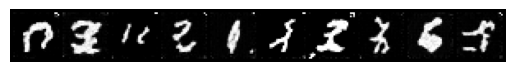

Training:  16%|█▌        | 3759/23500 [01:20<05:57, 55.23it/s, epoch=16/100, loss=⠀      0.0374, lr=6.87E-04]

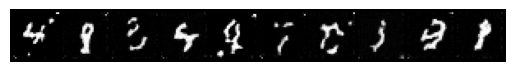

Training:  17%|█▋        | 3995/23500 [01:25<05:48, 56.04it/s, epoch=17/100, loss=⠀      0.0441, lr=6.71E-04]

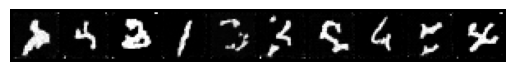

Training:  18%|█▊        | 4229/23500 [01:30<05:45, 55.81it/s, epoch=18/100, loss=⠀      0.0424, lr=6.55E-04]

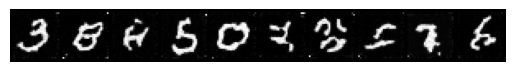

Training:  19%|█▉        | 4464/23500 [01:35<05:43, 55.40it/s, epoch=19/100, loss=⠀      0.0384, lr=6.40E-04]

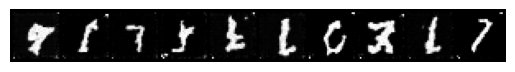

Training:  20%|█▉        | 4699/23500 [01:40<05:39, 55.32it/s, epoch=20/100, loss=⠀      0.0343, lr=6.25E-04]

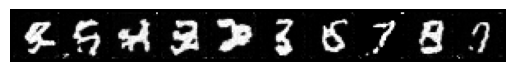

Training:  21%|██        | 4934/23500 [01:46<05:38, 54.92it/s, epoch=21/100, loss=⠀      0.0358, lr=6.10E-04]

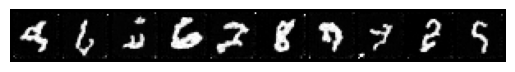

Training:  22%|██▏       | 5169/23500 [01:51<05:31, 55.37it/s, epoch=22/100, loss=⠀      0.0413, lr=5.96E-04]

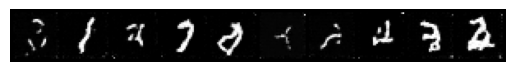

Training:  23%|██▎       | 5405/23500 [01:56<05:22, 56.12it/s, epoch=23/100, loss=⠀      0.0323, lr=5.82E-04]

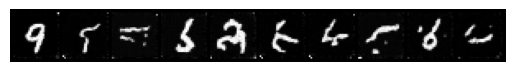

Training:  24%|██▍       | 5639/23500 [02:01<05:22, 55.31it/s, epoch=24/100, loss=⠀      0.0329, lr=5.69E-04]

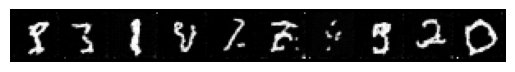

Training:  25%|██▍       | 5874/23500 [02:06<05:20, 54.95it/s, epoch=25/100, loss=⠀      0.0414, lr=5.56E-04]

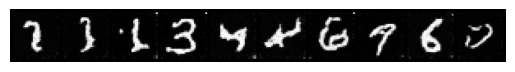

Training:  26%|██▌       | 6109/23500 [02:11<05:15, 55.18it/s, epoch=26/100, loss=⠀      0.0325, lr=5.43E-04]

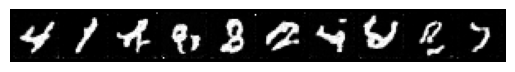

Training:  27%|██▋       | 6344/23500 [02:16<05:09, 55.37it/s, epoch=27/100, loss=⠀      0.0398, lr=5.30E-04]

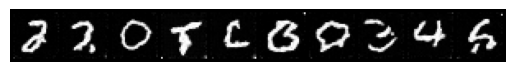

Training:  28%|██▊       | 6579/23500 [02:21<05:04, 55.55it/s, epoch=28/100, loss=⠀      0.0422, lr=5.18E-04]

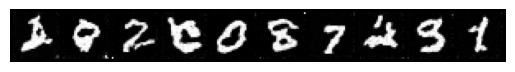

Training:  29%|██▉       | 6815/23500 [02:26<04:53, 56.77it/s, epoch=29/100, loss=⠀      0.0375, lr=5.06E-04]

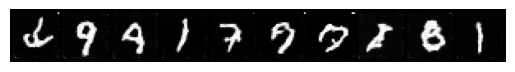

Training:  30%|██▉       | 7049/23500 [02:32<04:57, 55.25it/s, epoch=30/100, loss=⠀      0.0267, lr=4.94E-04]

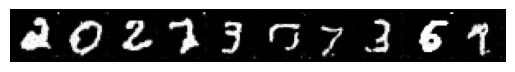

Training:  31%|███       | 7284/23500 [02:37<04:50, 55.89it/s, epoch=31/100, loss=⠀      0.0304, lr=4.83E-04]

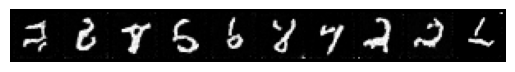

Training:  32%|███▏      | 7519/23500 [02:41<04:09, 63.99it/s, epoch=32/100, loss=⠀      0.0372, lr=4.71E-04]

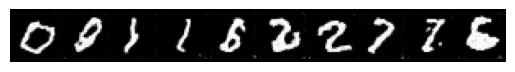

Training:  33%|███▎      | 7754/23500 [02:46<04:06, 63.79it/s, epoch=33/100, loss=⠀      0.0302, lr=4.60E-04]

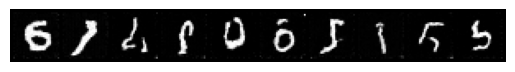

Training:  34%|███▍      | 7989/23500 [02:51<04:40, 55.22it/s, epoch=34/100, loss=⠀      0.0384, lr=4.50E-04]

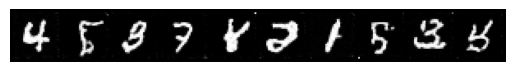

Training:  35%|███▍      | 8224/23500 [02:56<04:35, 55.37it/s, epoch=35/100, loss=⠀      0.0458, lr=4.39E-04]

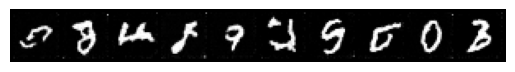

Training:  36%|███▌      | 8459/23500 [03:01<04:31, 55.50it/s, epoch=36/100, loss=⠀      0.0358, lr=4.29E-04]

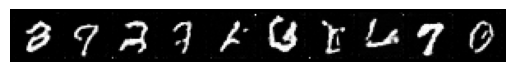

Training:  37%|███▋      | 8694/23500 [03:07<04:26, 55.50it/s, epoch=37/100, loss=⠀      0.0469, lr=4.19E-04]

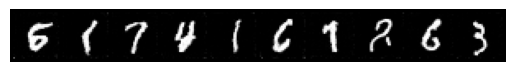

Training:  38%|███▊      | 8930/23500 [03:12<04:19, 56.12it/s, epoch=38/100, loss=⠀      0.0275, lr=4.09E-04]

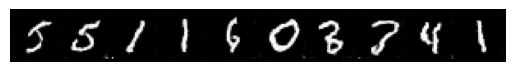

Training:  39%|███▉      | 9164/23500 [03:17<04:17, 55.58it/s, epoch=39/100, loss=⠀      0.0320, lr=4.00E-04]

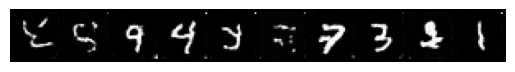

Training:  40%|███▉      | 9399/23500 [03:22<04:15, 55.29it/s, epoch=40/100, loss=⠀      0.0396, lr=3.91E-04]

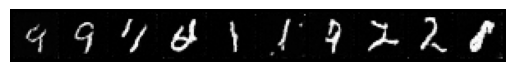

Training:  41%|████      | 9634/23500 [03:27<04:10, 55.33it/s, epoch=41/100, loss=⠀      0.0361, lr=3.82E-04]

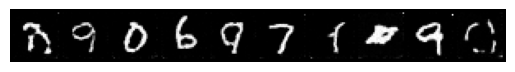

Training:  42%|████▏     | 9869/23500 [03:32<04:04, 55.67it/s, epoch=42/100, loss=⠀      0.0299, lr=3.73E-04]

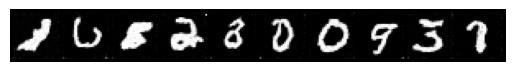

Training:  43%|████▎     | 10104/23500 [03:37<04:02, 55.33it/s, epoch=43/100, loss=⠀      0.0301, lr=3.64E-04]

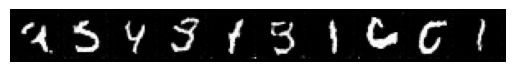

Training:  44%|████▍     | 10339/23500 [03:42<03:57, 55.35it/s, epoch=44/100, loss=⠀      0.0288, lr=3.56E-04]

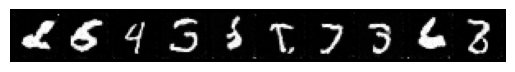

Training:  45%|████▍     | 10574/23500 [03:47<03:52, 55.58it/s, epoch=45/100, loss=⠀      0.0262, lr=3.47E-04]

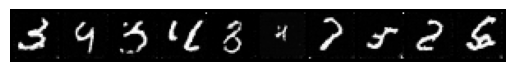

Training:  46%|████▌     | 10810/23500 [03:53<03:45, 56.25it/s, epoch=46/100, loss=⠀      0.0323, lr=3.39E-04]

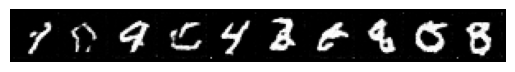

Training:  47%|████▋     | 11044/23500 [03:58<03:38, 57.12it/s, epoch=47/100, loss=⠀      0.0430, lr=3.31E-04]

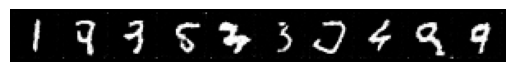

Training:  48%|████▊     | 11279/23500 [04:03<04:04, 50.03it/s, epoch=48/100, loss=⠀      0.0380, lr=3.24E-04]

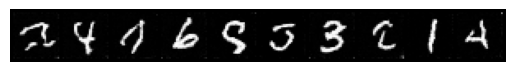

Training:  49%|████▉     | 11514/23500 [04:08<03:29, 57.18it/s, epoch=49/100, loss=⠀      0.0354, lr=3.16E-04]

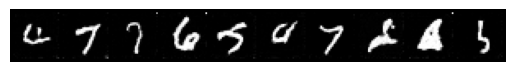

Training:  50%|████▉     | 11749/23500 [04:13<03:24, 57.48it/s, epoch=50/100, loss=⠀      0.0494, lr=3.09E-04]

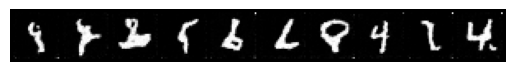

Training:  51%|█████     | 11984/23500 [04:18<03:19, 57.75it/s, epoch=51/100, loss=⠀      0.0309, lr=3.02E-04]

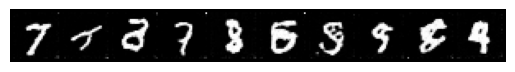

Training:  52%|█████▏    | 12219/23500 [04:23<03:18, 56.94it/s, epoch=52/100, loss=⠀      0.0406, lr=2.95E-04]

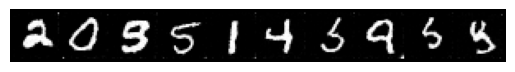

Training:  53%|█████▎    | 12455/23500 [04:28<03:10, 57.86it/s, epoch=53/100, loss=⠀      0.0286, lr=2.88E-04]

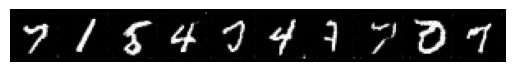

Training:  54%|█████▍    | 12689/23500 [04:33<03:08, 57.43it/s, epoch=54/100, loss=⠀      0.0265, lr=2.81E-04]

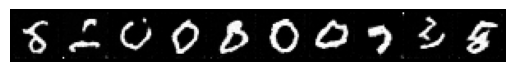

Training:  55%|█████▍    | 12924/23500 [04:38<03:06, 56.77it/s, epoch=55/100, loss=⠀      0.0337, lr=2.75E-04]

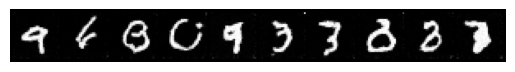

Training:  56%|█████▌    | 13159/23500 [04:43<03:02, 56.65it/s, epoch=56/100, loss=⠀      0.0298, lr=2.68E-04]

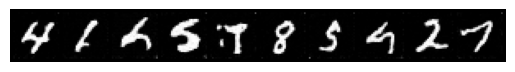

Training:  57%|█████▋    | 13394/23500 [04:48<02:56, 57.15it/s, epoch=57/100, loss=⠀      0.0344, lr=2.62E-04]

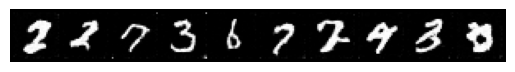

Training:  58%|█████▊    | 13629/23500 [04:53<02:53, 56.90it/s, epoch=58/100, loss=⠀      0.0343, lr=2.56E-04]

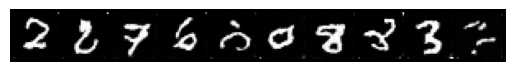

Training:  59%|█████▉    | 13865/23500 [04:58<02:46, 57.76it/s, epoch=59/100, loss=⠀      0.0281, lr=2.50E-04]

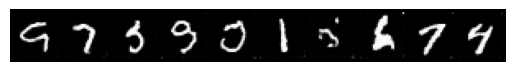

Training:  60%|█████▉    | 14099/23500 [05:03<02:42, 57.70it/s, epoch=60/100, loss=⠀      0.0323, lr=2.44E-04]

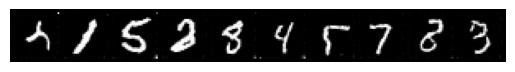

Training:  61%|██████    | 14334/23500 [05:08<02:39, 57.30it/s, epoch=61/100, loss=⠀      0.0295, lr=2.38E-04]

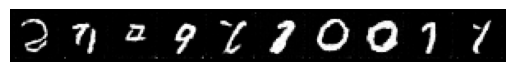

Training:  62%|██████▏   | 14569/23500 [05:13<02:35, 57.55it/s, epoch=62/100, loss=⠀      0.0290, lr=2.33E-04]

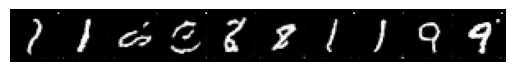

Training:  63%|██████▎   | 14804/23500 [05:18<02:32, 57.09it/s, epoch=63/100, loss=⠀      0.0304, lr=2.28E-04]

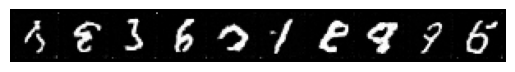

Training:  64%|██████▍   | 15039/23500 [05:23<02:26, 57.63it/s, epoch=64/100, loss=⠀      0.0243, lr=2.22E-04]

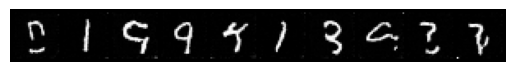

Training:  65%|██████▍   | 15274/23500 [05:28<02:23, 57.37it/s, epoch=65/100, loss=⠀      0.0357, lr=2.17E-04]

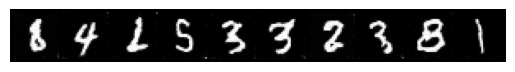

Training:  66%|██████▌   | 15509/23500 [05:33<02:19, 57.23it/s, epoch=66/100, loss=⠀      0.0388, lr=2.12E-04]

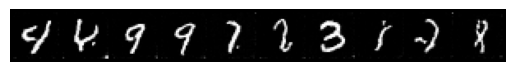

Training:  67%|██████▋   | 15745/23500 [05:38<02:13, 58.17it/s, epoch=67/100, loss=⠀      0.0373, lr=2.07E-04]

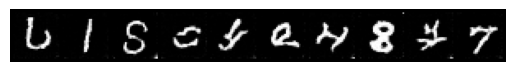

Training:  68%|██████▊   | 15979/23500 [05:43<02:10, 57.60it/s, epoch=68/100, loss=⠀      0.0290, lr=2.02E-04]

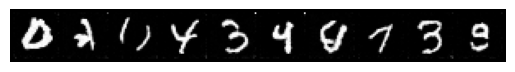

Training:  69%|██████▉   | 16214/23500 [05:48<02:07, 57.13it/s, epoch=69/100, loss=⠀      0.0349, lr=1.98E-04]

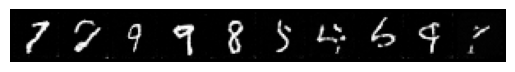

Training:  70%|██████▉   | 16449/23500 [05:53<02:03, 57.26it/s, epoch=70/100, loss=⠀      0.0321, lr=1.93E-04]

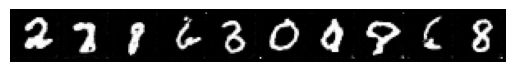

Training:  71%|███████   | 16684/23500 [05:58<01:58, 57.29it/s, epoch=71/100, loss=⠀      0.0335, lr=1.89E-04]

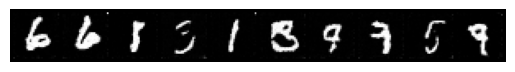

Training:  72%|███████▏  | 16919/23500 [06:03<01:55, 56.87it/s, epoch=72/100, loss=⠀      0.0290, lr=1.84E-04]

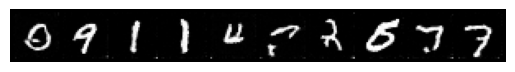

Training:  73%|███████▎  | 17155/23500 [06:08<01:52, 56.47it/s, epoch=73/100, loss=⠀      0.0282, lr=1.80E-04]

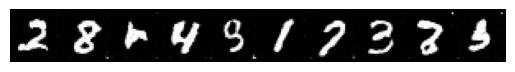

Training:  74%|███████▍  | 17389/23500 [06:13<01:47, 56.63it/s, epoch=74/100, loss=⠀      0.0334, lr=1.76E-04]

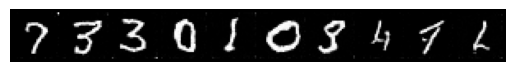

Training:  75%|███████▍  | 17624/23500 [06:18<01:43, 56.78it/s, epoch=75/100, loss=⠀      0.0322, lr=1.72E-04]

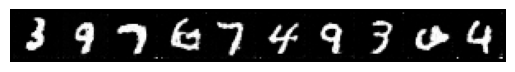

Training:  76%|███████▌  | 17859/23500 [06:23<01:38, 57.10it/s, epoch=76/100, loss=⠀      0.0375, lr=1.68E-04]

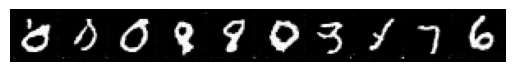

Training:  77%|███████▋  | 18094/23500 [06:28<01:35, 56.87it/s, epoch=77/100, loss=⠀      0.0299, lr=1.64E-04]

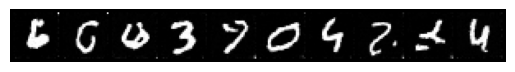

Training:  78%|███████▊  | 18329/23500 [06:33<01:30, 56.96it/s, epoch=78/100, loss=⠀      0.0298, lr=1.60E-04]

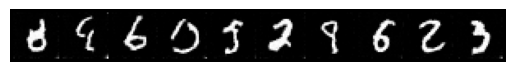

Training:  79%|███████▉  | 18564/23500 [06:38<01:27, 56.56it/s, epoch=79/100, loss=⠀      0.0327, lr=1.56E-04]

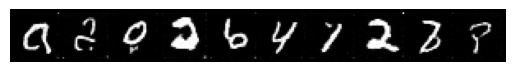

Training:  80%|███████▉  | 18799/23500 [06:43<01:30, 51.75it/s, epoch=80/100, loss=⠀      0.0338, lr=1.53E-04]

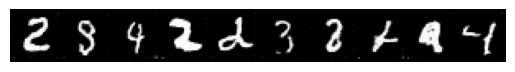

Training:  81%|████████  | 19034/23500 [06:48<01:18, 56.89it/s, epoch=81/100, loss=⠀      0.0329, lr=1.49E-04]

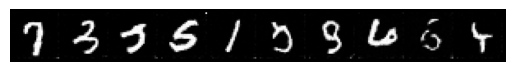

Training:  82%|████████▏ | 19269/23500 [06:53<01:07, 62.25it/s, epoch=82/100, loss=⠀      0.0282, lr=1.46E-04]

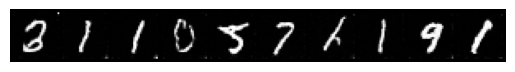

Training:  83%|████████▎ | 19504/23500 [06:58<01:04, 62.20it/s, epoch=83/100, loss=⠀      0.0230, lr=1.42E-04]

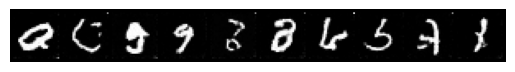

Training:  84%|████████▍ | 19740/23500 [07:02<00:59, 63.62it/s, epoch=84/100, loss=⠀      0.0275, lr=1.39E-04]

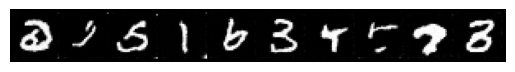

Training:  85%|████████▍ | 19974/23500 [07:07<00:56, 62.29it/s, epoch=85/100, loss=⠀      0.0244, lr=1.36E-04]

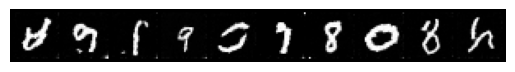

Training:  86%|████████▌ | 20209/23500 [07:12<00:52, 62.47it/s, epoch=86/100, loss=⠀      0.0365, lr=1.33E-04]

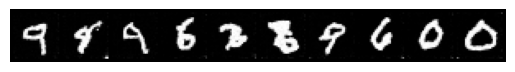

Training:  87%|████████▋ | 20444/23500 [07:16<00:48, 62.58it/s, epoch=87/100, loss=⠀      0.0289, lr=1.29E-04]

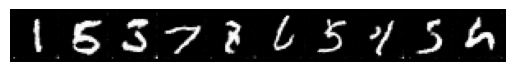

Training:  88%|████████▊ | 20679/23500 [07:21<00:45, 62.49it/s, epoch=88/100, loss=⠀      0.0354, lr=1.26E-04]

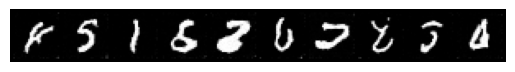

Training:  89%|████████▉ | 20915/23500 [07:26<00:40, 63.41it/s, epoch=89/100, loss=⠀      0.0299, lr=1.23E-04]

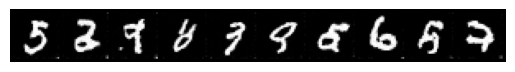

Training:  90%|████████▉ | 21149/23500 [07:30<00:37, 62.42it/s, epoch=90/100, loss=⠀      0.0382, lr=1.21E-04]

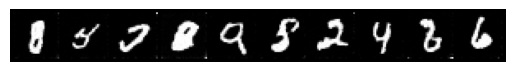

Training:  91%|█████████ | 21384/23500 [07:35<00:36, 57.81it/s, epoch=91/100, loss=⠀      0.0374, lr=1.18E-04]

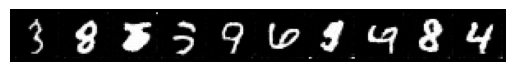

Training:  92%|█████████▏| 21619/23500 [07:40<00:30, 62.48it/s, epoch=92/100, loss=⠀      0.0302, lr=1.15E-04]

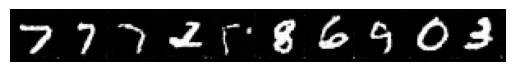

Training:  93%|█████████▎| 21855/23500 [07:44<00:26, 63.24it/s, epoch=93/100, loss=⠀      0.0347, lr=1.12E-04]

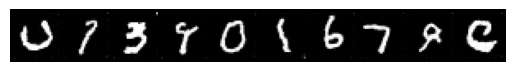

Training:  94%|█████████▍| 22089/23500 [07:49<00:22, 62.49it/s, epoch=94/100, loss=⠀      0.0302, lr=1.10E-04]

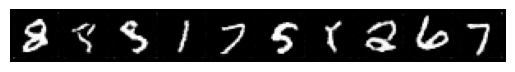

Training:  95%|█████████▍| 22324/23500 [07:54<00:18, 62.79it/s, epoch=95/100, loss=⠀      0.0382, lr=1.07E-04]

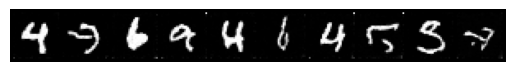

Training:  96%|█████████▌| 22559/23500 [07:58<00:14, 63.18it/s, epoch=96/100, loss=⠀      0.0290, lr=1.05E-04]

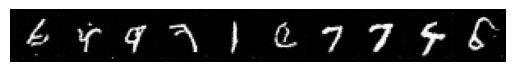

Training:  97%|█████████▋| 22794/23500 [08:03<00:11, 62.29it/s, epoch=97/100, loss=⠀      0.0227, lr=1.02E-04]

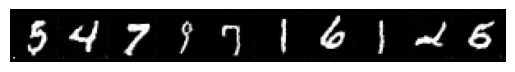

Training:  98%|█████████▊| 23030/23500 [08:08<00:07, 63.19it/s, epoch=98/100, loss=⠀      0.0333, lr=9.99E-05]

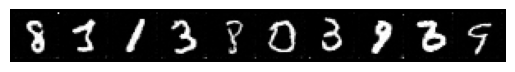

Training:  99%|█████████▉| 23264/23500 [08:12<00:03, 62.24it/s, epoch=99/100, loss=⠀      0.0306, lr=9.76E-05]

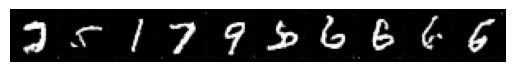

Training: 100%|█████████▉| 23499/23500 [08:17<00:00, 62.58it/s, epoch=100/100, loss=⠀      0.0262, lr=9.54E-05]

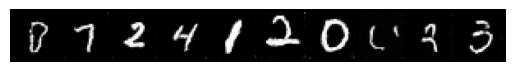

Training: 100%|██████████| 23500/23500 [08:18<00:00, 47.14it/s, epoch=100/100, loss=⠀      0.0262, lr=9.54E-05]


In [5]:
# Call training loop
train(model, optimizer, scheduler, dataloader_train, 
      epochs=epochs, device=device, ema=True, per_epoch_callback=reporter)

Evaluate baseline

In [6]:
# baseline: DDPM predicting noise
baseline_loss = evaluate(model, dataloader_test, device, 'Baseline')

/opt/conda_env/jmj/miniconda3/envs/plm_env/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_1999011/2482319247.py:314: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample = torch.tensor(samples, dtype=torch.uint8).view(batch_size, 1, 28, 28).repeat(1,3,1,1)
/tmp/ipykernel_1999011/2482319247.py:323: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imgs_dist1 = torch.tensor(x[:batch_size,:], dtype=torch.uint8).view(batch_size, 1, 28, 28).repeat(1,3,1,1)
Evaluating: 100%|██████████| 40/40 [06:03<00:00,  9.09s/it]

Mean of IS means: 1.7483822107315063
Mean of IS stds: 0.03115798905491829
Mean FID score: 2.4954095351858996e-05
